In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 64

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

Multi-Head Attention (MHA) uses multiple attention heads to process different parts of the input simultaneously along the embedding dimension. Each head calculates attention independently by applying different projections of the queries, keys, and values. The outputs from each head are then concatenated and transformed through a final linear layer, allowing the model to capture various relationships and patterns.

Note: this is a very slow implemenation, it's made to simplify the intuition behind MHA. Pytorch implementation of MHA is far better

In [4]:
class FlashAttention(nn.Module): 
    def __init__(self, emb_size, head_size):
        super(FlashAttention, self).__init__()
        self.head_size = head_size 

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=True):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        attention = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        attention = self.rvalues(attention)
        return attention
    
    
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, n_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(emb_size, n_heads, batch_first=True)

    def forward(self, x):
        mask = torch.nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)
        x, _ = self.mha(x, x, x, attn_mask=mask)
        return x
    
    
class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) 
        x = self.fc2(x)
        return x

    
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers, attention):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = attention
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
    
        return x
    
    
class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers, attention):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers, attention) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x

Number of parameters: 1.11M
Epoch _600 - Loss: 1.799
Epoch 1200 - Loss: 1.660
Epoch 1800 - Loss: 1.584
Epoch 2400 - Loss: 1.517
Epoch 3000 - Loss: 1.501
Number of parameters: 1.11M
Epoch _600 - Loss: 1.924
Epoch 1200 - Loss: 1.657
Epoch 1800 - Loss: 1.581
Epoch 2400 - Loss: 1.487
Epoch 3000 - Loss: 1.455


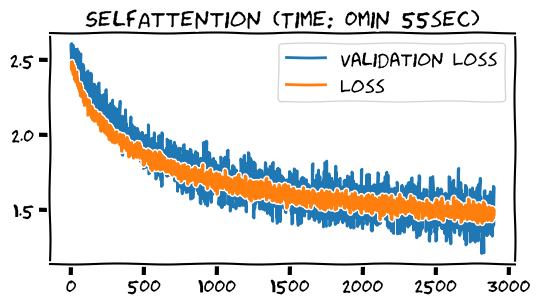

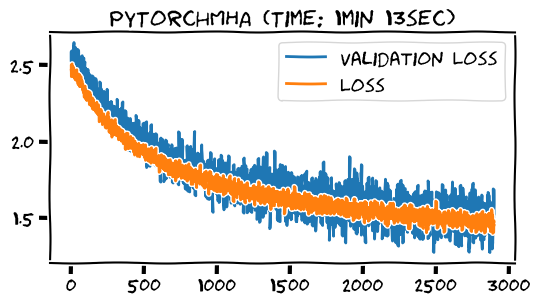

In [ ]:
import time
# todo rewrite to be able to plot different runs in the same chart 

for attention in [FlashAttention(256, 256), MultiHeadAttention(256, 8)]:
    device = torch.device("cuda:0")
    model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=1, attention=attention).to(device)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    epochs = 3000
    batch_size = 256
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

    lossi = []
    vlossi = []

    start_time = time.time()
    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs), (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        if (epoch+1) % (epochs//5) == 0:  # Moving epoch by 1 to get the last value of the loss 
            print(f"Epoch {epoch+1:_>4d} - Loss: {loss.item():.3f}")

        with torch.no_grad():
            indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

            pred = model(val_inputs[indexes].to(device))
            loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
            vlossi.append(loss.item())
            
    del model
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(6, 3))  
    plt.title(attention.__class__.__name__ + f" (Time: {int((time.time()-start_time)/60)}min {int((time.time()-start_time)%60)}sec)")
    plt.plot(vlossi, label='Validation Loss')
    plt.plot(lossi, label='Loss')
    plt.legend()

### Mixture of Experts (MoE)

Models typically encode information in their weights, but not all weights are necessary for every task. For example, if a set of weights primarily encodes city names, they are unnecessary when the task involves solving a quadratic equation.

This leads to the idea of using multiple sets of weights that the model can choose from dynamically, enabling more efficient computation. For instance, the Mistral Mixture of Experts model employs 8 sets of 7B parameters, but only 13B parameters are active at any given time, offering a 3-4x speedup over a similar model without MoE, with minimal impact on performance. GPT-4 also uses an MoE approach, combining 16 experts of 110B parameters each.

However, this requires additional infrastructure, like a router that decides which experts to activate, and may require human input to determine how experts should be trained. Empirically, the way experts are chosen can be opaque, and it's not trivial to prevent a single expert from dominating, leaving the others underutilized.

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, in_size, out_size, hidden_size):
        super(FullyConnected, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = self.LayerNorm(x)
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.out(x)
        return x

class MoE(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, depth=4, n_experts=5):
        super(MoE, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fcin = nn.Linear(sequence_length, n_experts)
        self.experts = nn.ModuleList(FullyConnected(in_size, out_size, hidden_size) for _ in range(n_experts))
        self.fcout = nn.Linear(hidden_size, out_size)

    def forward(self, x, chosen_expert=None):
        
        experts = F.gelu(self.fcin(x[:, :, 0]))
        choice = torch.multinomial(torch.softmax(experts, 1), 1)[:, 0]
        
        if chosen_expert is None: # It might be that i goth this the other way around, doesnt matter if depth and n_experts are the same
            for n, expert in enumerate(self.experts):
                x[choice==n] = expert(x[choice==n])
        else:
            x = self.experts[chosen_expert](x)
        
        x = self.fcout(x)
        return x
    
class Block(nn.Module):
    def __init__(self, emb_size, head_size, hidden_size, n_layers, n_heads, n_experts):
        super().__init__()

        self.norm = nn.LayerNorm(emb_size)
        self.att = MultiHeadAttention(emb_size, n_heads)
        self.MoE = MoE(in_size=emb_size, out_size=emb_size, hidden_size=hidden_size, depth=n_layers, n_experts=n_experts)


    def forward(self, x, chosen_expert=None): 

        x = x + self.att(self.norm(x)) 
        x = x + self.MoE(self.norm(x), chosen_expert)

        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2, n_heads=4, n_experts=8):
        super(Transformer, self).__init__()

        self.pemb = nn.Embedding(sequence_length, emb_size)
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers, n_heads, n_experts) for i in range(n_blocks)])
        self.lout = nn.Linear(emb_size, vocab_size)

    def forward(self, x, chosen_expert=None):
        x = self.emb(x)
        pemb = self.pemb(torch.arange(sequence_length).to(device))
        
        x = x + pemb
        
        for block in self.blocks:
            x = x + block(x, chosen_expert=chosen_expert)
        
        x = self.lout(x)
        return x

model = Transformer(vocab_size=65, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2, n_heads=4, n_experts=4).to(device)

lossi = []
vlossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [25]:
%%time
epochs = 6000
batch_size = 256
print("Percent of dataset: ", epochs*batch_size / inputs.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

Percent of dataset:  1.3796460884428592


  0%|          | 1/6000 [00:00<12:51,  7.78it/s]

23.41286277770996


 10%|█         | 603/6000 [00:57<08:18, 10.83it/s]

4.554219722747803


 20%|██        | 1202/6000 [01:54<07:36, 10.50it/s]

3.7533035278320312


 30%|███       | 1801/6000 [02:52<06:35, 10.62it/s]

2.819862127304077


 40%|████      | 2401/6000 [03:46<05:17, 11.34it/s]

2.765425443649292


 50%|█████     | 3003/6000 [04:38<04:15, 11.73it/s]

2.6238796710968018


 60%|██████    | 3603/6000 [05:30<03:29, 11.42it/s]

2.5925655364990234


 70%|███████   | 4203/6000 [06:23<02:34, 11.66it/s]

2.5515835285186768


 80%|████████  | 4803/6000 [07:15<01:44, 11.51it/s]

2.5253405570983887


 90%|█████████ | 5401/6000 [08:07<00:53, 11.10it/s]

2.4645397663116455


100%|██████████| 6000/6000 [08:59<00:00, 11.11it/s]

CPU times: user 22min 54s, sys: 2.34 s, total: 22min 56s
Wall time: 8min 59s


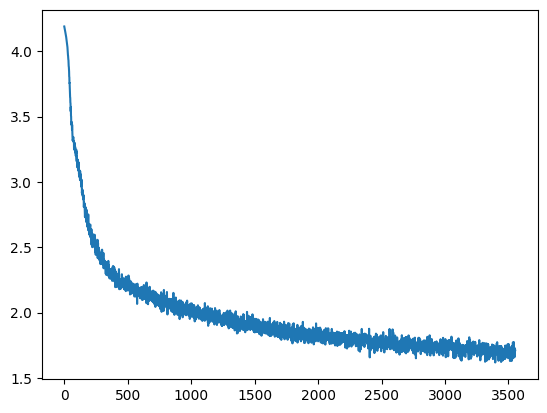

In [9]:
plt.plot(torch.tensor(lossi[::]).view(-1, 1).mean(1))

In [10]:
# val accuracy

pred = model(val_inputs.to(device))
pred = torch.argmax(pred, dim=1)
val_labels = val_labels.to(device)
acc = (pred == val_labels).float().mean()
print("Validation accuracy of MoE: ", acc)

for chosen in range(8):
    pred = model(val_inputs.to(device), chosen_expert=chosen)
    pred = torch.argmax(pred, dim=1)
    val_labels = val_labels.to(device)
    acc = (pred == val_labels).float().mean()
    print("Validation accuracy of expert", chosen, ": ", acc)


Validation accuracy of MoE:  tensor(0.4875, device='cuda:0')
Validation accuracy of expert 0 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 1 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 2 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 3 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 4 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 5 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 6 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 7 :  tensor(0.3485, device='cuda:0')


### Expert Utilization

When training with multiple experts and testing with only a specific one, we observe lower accuracy compared to letting the router decide which expert to use. This shows that the Mixture of Experts (MoE) mechanism is actively contributing to model performance by dynamically selecting the most relevant experts for each task.